In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Input, Model
from keras.layers import Dense, Layer
from pycalphad import Database, calculate, variables as v
import numpy as np

In [2]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'ZN', 'VA']

In [3]:
import pycalphad
mod = pycalphad.Model(dbf, comps, 'LIQUID')
#del mod.models['idmix']
#del mod.models['ref']
print(mod.models)
res = calculate(dbf, comps, 'LIQUID', T=(300, 1600, 10), P=1e5, N=1, model=mod, pdens=10)

OrderedDict([('ref', (LIQUID0MG*Piecewise((8202.243 - 8.83693*T - 8.0176e-20*T**7 + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 923.0, 298.15 <= T)), (8690.316 - 9.392158*T - 1.038192e+28*T**(-9) + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)), And(T < 6000.0, 923.0 <= T)), (0, True)) + LIQUID0SI*Piecewise((50696.4 - 30.0994*T + 2.09307e-21*T**7 + Piecewise((-8162.609 + 137.236859*T - 22.8317533*T*log(T) + 176667*T**(-1) - 0.001912904*T**2 - 3.552e-09*T**3, And(T < 1687.0, 298.15 <= T)), (-9457.642 + 167.281367*T - 27.196*T*log(T) - 4.20369e+30*T**(-9), And(T < 3600.0, 1

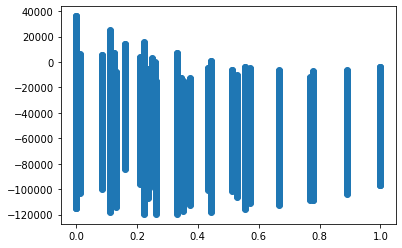

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [5]:
site_fractions = res.Y.values
print(site_fractions.shape)

(1, 1, 130, 53, 3)


In [6]:
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .drop_duplicates()\
                .reset_index()\
                .drop(columns=['N', 'P', 'points'])
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .reset_index().drop(columns=['N', 'P', 'points'])
print(filtered.shape)
# Not sure how to fix the duplicate energy column yet
filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
x_orig = filtered[:, :-1]
y_orig = filtered[:, -1]

(20670, 7)


C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
filtered

array([[ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e-14, -4.25029576e+03],
       [ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e-14, -4.25029576e+03],
       [ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e-14, -4.25029576e+03],
       ...,
       [ 1.59000000e+03,  3.73514633e-01,  1.99856959e-01,
         4.26628408e-01, -1.12834275e+05],
       [ 1.59000000e+03,  3.73514633e-01,  1.99856959e-01,
         4.26628408e-01, -1.12834275e+05],
       [ 1.59000000e+03,  3.73514633e-01,  1.99856959e-01,
         4.26628408e-01, -1.12834275e+05]])

In [25]:
class ConcatLayer(Layer):
    def __init__(self, temp_scale=1.0):
        super().__init__()
        self.temp_scale = float(temp_scale)
    def build(self, input_shape):
        self.scale_factor = tf.constant([1./self.temp_scale] + ([1.0] * (input_shape[-1]-1)))
    def call(self, inputs):
        scaled_inputs = inputs * self.scale_factor
        return scaled_inputs
        #return tf.concat([scaled_inputs, tf.math.log(scaled_inputs[..., :1])], axis=-1)

In [26]:
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from tensorflow_addons.layers import PolynomialCrossing

x = x_orig.copy()
#x[:, 0] /= x_orig[:, 0].std()
print('Number of training points: ', x.shape[0])
y_unscaled = y_orig #- 8.3145 * x_orig[:, 0] * (x_orig[:, 1] * np.log(x_orig[:, 1]) + x[:, 2] * np.log(x_orig[:, 2]))
y = y_unscaled #/ y_unscaled.std() # (y_unscaled - y_unscaled.mean())/y_unscaled.std()
print('Number of features: ', x.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
x0 = ConcatLayer(temp_scale=x_orig[:, 0].max())(inputs)
#x0 = inputs
#x0 = BatchNormalization()(x0)
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, x0))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))

output = y_unscaled.std() * tf.math.reduce_sum(output, axis=-1) + \
    8.3145*inputs[...,0] * (inputs[...,1]*tf.math.log(inputs[...,1]) + inputs[...,2]*tf.math.log(inputs[...,2]) + inputs[...,3]*tf.math.log(inputs[...,3]))
linear_model = Model(inputs, output)
#linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss='mse')
linear_model.compile(optimizer='adam', loss='mae')

Number of training points:  20670
Number of features:  4


In [27]:
ConcatLayer(temp_scale=x_orig[:, 0].max())(x_test)

<tf.Tensor: shape=(2067, 4), dtype=float32, numpy=
array([[3.8993710e-01, 2.1171974e-01, 5.5008870e-01, 2.3819157e-01],
       [2.8930816e-01, 2.1171974e-01, 5.5008870e-01, 2.3819157e-01],
       [4.7169811e-01, 3.4401020e-01, 2.0123306e-01, 4.5475674e-01],
       ...,
       [4.2138365e-01, 1.1111111e-01, 9.9999998e-15, 8.8888890e-01],
       [7.6100630e-01, 2.6127702e-01, 2.6316660e-02, 7.1240634e-01],
       [5.4088050e-01, 5.5555558e-01, 9.9999998e-15, 4.4444445e-01]],
      dtype=float32)>

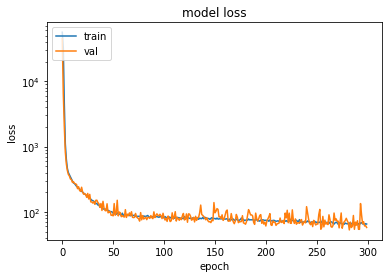

In [28]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=300, validation_data=(x_test, y_test), verbose=0,
                           callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

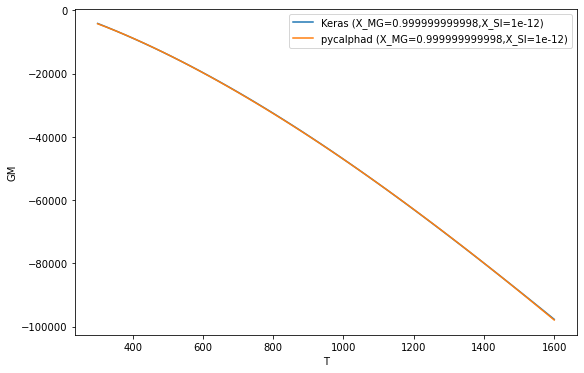

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_at_composition(x_mg, x_si):
    x_start = np.array([300,x_mg, x_si, 1-(x_mg+x_si)])
    x_end = np.array([1600, x_mg, x_si, 1-(x_mg+x_si)])
    x_interp = np.linspace(x_start, x_end, num=50)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'LIQUID')
    #del mod.models['idmix']
    #del mod.models['ref']
    test_calc = calculate(dbf, comps, 'LIQUID',model=mod, T=x_interp[:,0], N=1, P=1e5,
                          points=[[x_mg, x_si, 1-(x_mg+x_si)]])
    #test_calc
    ax.plot(x_interp[:,0], model_y, label=f'Keras (X_MG={x_mg},X_SI={x_si})')
    ax.plot(x_interp[:,0], np.squeeze(test_calc.GM.values),
            label=f'pycalphad (X_MG={x_mg},X_SI={x_si})')
#plot_at_composition(0.2)
#plot_at_composition(0.4)
plot_at_composition(1-(2*1e-12), 1e-12)
ax.set_xlabel('T')
ax.set_ylabel('GM')
ax.legend()

In [30]:
linear_model.weights

[<tf.Variable 'polynomial_crossing_8/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.16290371, -1.0244926 ,  0.26910323, -0.8902545 ],
        [ 0.05187767, -0.6163748 ,  0.04941815, -2.3328214 ],
        [ 0.03853191, -0.81688285,  0.8164113 , -0.7971609 ],
        [ 0.3507483 , -1.3033789 ,  0.80099154, -0.83775705]],
       dtype=float32)>,
 <tf.Variable 'polynomial_crossing_9/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.33860722, -0.7991576 ,  0.23002471, -0.83556825],
        [-0.29412472, -0.46720886,  0.24511959, -2.2626388 ],
        [-0.22962685, -0.6944119 ,  0.22460622, -0.05838889],
        [-0.84897006, -1.1207495 ,  0.7635846 ,  0.03633455]],
       dtype=float32)>,
 <tf.Variable 'polynomial_crossing_10/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.5979506 , -0.75195575,  0.6019687 , -0.5681829 ],
        [ 0.01369908, -0.21395756,  0.05556906, -0.29164794],
        [ 0.04606892, -0.5260624 , -0.01075258, -0.21026985],
        [ 0.00901384,